In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tqdm
import timeit
import textwrap
import sklearn
import xgboost

from scipy import stats
from scipy.stats import zscore
from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


from sklearn.model_selection import GridSearchCV


pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [21]:
path = 'C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive/*.csv'
input_files = glob.glob(path)

In [22]:
def file_load(path):
        
    for i, file in enumerate(input_files):
        print(file)
        globals()[f'df{i+1}'] = pd.read_csv(input_files[i])
    print(f'Total number of files loaded: {len(input_files)}')
    
file_load(path)

C:/Users/delst/OneDrive - Queen Mary, University of London/Desktop/VSCode/Advanced_Projects/Uber_Demand_Project/data_archive\uber.csv
Total number of files loaded: 1


In [23]:
df_store = [eval(f'df{i+1}') for i in range(len(input_files))]   # Dataframe preperation

---

# **Initial Exploration**

In [24]:
keys_list = [df_store[i].keys() for i in range(len(df_store))]
flattened_list = [item for sublist in keys_list for item in sublist]
unique_keys = list(set(flattened_list))

print('Number of unique keys:', len(unique_keys))
# print(keys_list)
unique_keys

Number of unique keys: 9


['dropoff_latitude',
 'Unnamed: 0',
 'passenger_count',
 'key',
 'pickup_datetime',
 'dropoff_longitude',
 'pickup_longitude',
 'pickup_latitude',
 'fare_amount']

In [25]:
df = df_store[0]
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [26]:
df.describe().round()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.0,200000.0,200000.0,200000.0,199999.0,199999.0,200000.0
mean,27712504.0,11.0,-73.0,40.0,-73.0,40.0,2.0
std,16013822.0,10.0,11.0,8.0,13.0,7.0,1.0
min,1.0,-52.0,-1341.0,-74.0,-3357.0,-882.0,0.0
25%,13825346.0,6.0,-74.0,41.0,-74.0,41.0,1.0
50%,27745495.0,8.0,-74.0,41.0,-74.0,41.0,1.0
75%,41555301.0,12.0,-74.0,41.0,-74.0,41.0,2.0
max,55423567.0,499.0,57.0,1644.0,1154.0,873.0,208.0


In [27]:
# from sklearn.model_selection import StratifiedShuffleSplit

# X = df.drop('target_column', axis=1)
# y = df['target_column']

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, test_index in sss.split(X, y):
#     df_sample = df.iloc[test_index]

In [28]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 42.1 MB


In [29]:
memory_usage = df.memory_usage(deep=True)
print(memory_usage/1000000)

Index                 0.000128
Unnamed: 0            1.600000
key                  16.936069
fare_amount           1.600000
pickup_datetime      16.000000
pickup_longitude      1.600000
pickup_latitude       1.600000
dropoff_longitude     1.600000
dropoff_latitude      1.600000
passenger_count       1.600000
dtype: float64


In [30]:
df.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [31]:
for col in df:
  print(df[col].unique())

[24238194 27835199 44984355 ... 27804658 20259894 11951496]
['2015-05-07 19:52:06.0000003' '2009-07-17 20:04:56.0000002'
 '2009-08-24 21:45:00.00000061' ... '2009-06-29 00:42:00.00000078'
 '2015-05-20 14:56:25.0000004' '2010-05-15 04:08:00.00000076']
[ 7.5   7.7  12.9  ... 37.2  86.25 89.1 ]
['2015-05-07 19:52:06 UTC' '2009-07-17 20:04:56 UTC'
 '2009-08-24 21:45:00 UTC' ... '2009-06-29 00:42:00 UTC'
 '2015-05-20 14:56:25 UTC' '2010-05-15 04:08:00 UTC']
[-73.99981689 -73.994355   -74.005043   ... -73.969204   -74.003548
 -73.99712372]
[40.73835373 40.728225   40.74077    ... 40.74391937 40.72121
 40.72545242]
[-73.99951172 -73.99471    -73.962565   ... -73.95223999 -74.01390839
 -73.858957  ]
[40.72321701 40.750325   40.772647   ... 40.692588   40.6954155
 40.768793  ]
[  1   3   5   2   4   6   0 208]


In [32]:
count = df['passenger_count'].eq(208).sum()
count

1

In [33]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [34]:
df = df[['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime','passenger_count']]
df

,Unnamed: 0,key,fare_amount,pickup_datetime,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,5
...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,1


In [35]:
frac = 0.01
df_frac = len(df)*frac
df = df.iloc[:int(df_frac),:]
df

,Unnamed: 0,key,fare_amount,pickup_datetime,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,5
...,...,...,...,...,...
1995,1471595,2012-03-16 21:00:35.0000006,8.5,2012-03-16 21:00:35 UTC,1
1996,15828110,2011-03-25 12:27:38.0000001,13.7,2011-03-25 12:27:38 UTC,1
1997,41730233,2011-05-14 02:24:00.000000184,7.3,2011-05-14 02:24:00 UTC,2
1998,6544585,2010-02-22 07:32:01.0000002,3.7,2010-02-22 07:32:01 UTC,2


---

In [36]:
class Dataset:
    def __init__(self, data, threshold):
        self.data = data
        self.threshold = threshold
    
    def data_transform(self):
        self.data['pickup_datetime'] = pd.to_datetime(self.data['pickup_datetime']).dt.tz_localize(None)
        self.data['pickup_datetime'] = self.data['pickup_datetime'].dt.floor('H')
        
        self.data['Label_Hour'] = self.data['pickup_datetime'].dt.hour
        self.data['Label_Date'] = self.data['pickup_datetime'].dt.date

        self.data['day_name'] = pd.to_datetime(self.data['pickup_datetime']).dt.day_name()
        self.data['day_of_the_week'] = pd.to_datetime(self.data['pickup_datetime']).dt.weekday
        return self.data
            
    def data_remove_outliers(self):
        self.data = self.data[(np.abs(stats.zscore(self.data['passenger_count'])) < 2)]
        self.data = self.data[(np.abs(stats.zscore(self.data['fare_amount'])) < 2)]
        self.data = self.data
        return self.data

    def data_clean(self):
        self.data['fare_amount'] = abs(self.data.fare_amount)
        self.data.passenger_count.replace(0, 1, inplace=True)
        self.data.fare_amount.replace(0, 1, inplace=True)
        self.data = self.data.dropna()
        return self.data
    
    def winsorization(self):
        median = self.data['sPED'].median()
        lower_quantile = self.data['sPED'].quantile(self.threshold)
        upper_quantile = self.data['sPED'].quantile(1-self.threshold)
        self.data['sPED'][self.data['sPED'] < lower_quantile] = -1*median
        self.data['sPED'][self.data['sPED'] > upper_quantile] = median
        return self.data
    
    def index_set(self):
        self.data = self.data.set_index('pickup_datetime')
        self.data.index = self.data.index.strftime('%Y-%m-%d-%H')
        return self.data
###########################################################################
###########################################################################

class GroupClass:
    def __init__(self, data, col_group):
        self.data = data
        self.col_group = col_group
    
    def group_by_hour(self, col_group):
        self.data = self.data[col_group].groupby(['pickup_datetime'])['passenger_count','fare_amount'].agg({'passenger_count':'mean','fare_amount':'mean'}).reset_index()
        return self.data
    
    def group_by_day(self, col_group):
        self.data = self.data[col_group].groupby(['Label_Date'])['passenger_count','fare_amount'].agg({'passenger_count':'mean','fare_amount':'mean'}).reset_index()
        return self.data
    
class FeatureExtraction:
    def __init__(self, data, col_feature, n_window):
        self.data = data
        self.col_feature = col_feature
        self.n_window = n_window

    def calc_pct_change(self, col_feature):
        for col in col_feature:
            self.data[col + '_pct_change'] = self.data[col].pct_change()
        return self.data
    
    def calc_sma(self, col, n_window):
        self.data[col + '_sma'] = self.data[col].rolling(window=self.n_window).mean()
        return self.data
        
    def calc_ema(self, col, n_window):
        self.data[col + '_ema'] = self.data[col].ewm(span=n_window, adjust=False).mean()
        return self.data
        
    def calc_sma_PED(self):
        self.data['sPED'] = self.data.passenger_count_pct_change_sma / self.data.fare_amount_pct_change_sma
        return self.data
        
    def calc_ema_PED(self):
        self.data['ePED'] = self.data.passenger_count_pct_change_ema / self.data.fare_amount_pct_change_ema
        return self.data

class ModelSelection:
    def __init__(self, data, input_columns, target_column, cv_splits, test_split):
        self.data = data
        self.input_columns = input_columns
        self.target_column = target_column
        self.cv_splits = cv_splits
        self.test_split = test_split
        # self.models = [DecisionTreeRegressor(random_state=0), LinearRegression(),
        #                RandomForestRegressor(), 
        #                SVR(C=1.0, epsilon=0.2), 
        #                xgboost.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=1-test_split)]
        self.models = {
            'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
            'LinearRegression': LinearRegression(),
            'RandomForestRegressor': RandomForestRegressor(), 
            'SVR': SVR(C=1.0, epsilon=0.2), 
            'XGBRegressor': xgboost.XGBRegressor(n_estimators=100, max_depth=5, eta=0.1, subsample=1-test_split)
        }
        
    def split_dataset(self):
        input_features = self.data.drop(input_columns, axis=1)
        target_variable = self.data[target_column]
        X_train, X_test, y_train, y_test = train_test_split(input_features, target_variable, shuffle=False, test_size=test_split)
        return X_train, X_test, y_train, y_test
    
    def model_evaluation(self, model, X_train, y_train, cv_splits):
        std_clf = make_pipeline(StandardScaler(), model)

        r2_scores = []
        mae_scores = []
        rmse_scores = []

        kf = KFold(n_splits=cv_splits, shuffle=False)
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

            std_clf.fit(X_train_cv, y_train_cv)
            y_pred = std_clf.predict(X_test_cv)

            r2_scores.append(r2_score(y_test_cv, y_pred))
            mae_scores.append(mean_absolute_error(y_test_cv, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, y_pred)))

        return {"Mean R^2": sum(r2_scores) / cv_splits, 
                "Mean MAE": sum(mae_scores) / cv_splits,
                "Mean RMSE": sum(rmse_scores) / cv_splits}
    
    def run_model_evaluation(self):
        X_train, X_test, y_train, y_test = self.split_dataset()
        best_model = None
        best_score = 0
        for model_name, model in self.models.items():
            # Define hyperparameters for grid search
            if model_name == 'DecisionTreeRegressor':
                params = {'max_depth': [5, 10, 15]}
            elif model_name == 'LinearRegression':
                params = {'fit_intercept': [True, False]}
            elif model_name == 'RandomForestRegressor':
                params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
            elif model_name == 'SVR':
                params = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
            elif model_name == 'XGBRegressor':
                params = {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150]}
                
            # Perform grid search
            grid = GridSearchCV(estimator=model, param_grid=params, cv=self.cv_splits, n_jobs=-1)
            grid.fit(X_train, y_train)
            
            # Determine if this model is the best so far
            if grid.best_score_ > best_score:
                best_score = grid.best_score_
                best_model = grid.best_estimator_
                best_params = grid.best_params_
        
        best_model_name = type(best_model).__name__
        if best_model_name == 'XGBRegressor':
            model_class = xgboost.XGBRegressor
        else:
            model_class = getattr(sklearn.ensemble, best_model_name)

        selected_model = model_class(**best_params)
        
        
        print('\n')
        print("Selected model: {}".format(type(best_model).__name__))
        print("Hyperparameters: {}".format(best_params))
        print("Model score: {}".format(best_score))
        print('\n')

        return best_model, selected_model
            
class Model:
    def __init__(self, data, X_train, y_train, selected_model, cv_splits):
        self.data = data
        self.X_train = X_train
        self.y_train = y_train
        self.selected_model = selected_model
        self.cv_splits = cv_splits

    def train_model(self):
        std_clf = make_pipeline(StandardScaler(), self.selected_model)
        kf = KFold(n_splits=self.cv_splits, shuffle=False)
        
        train_index, test_index = next(kf.split(self.X_train))
        X_train_cv, X_test_cv = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
        y_train_cv, y_test_cv = self.y_train.iloc[train_index], self.y_train.iloc[test_index]        
        
        std_clf.fit(X_train_cv, y_train_cv)
        self.std_clf = std_clf
        self.kf = kf
        return self.std_clf, self.kf

    def validate_model(self):
        y_pred_train = cross_val_predict(self.std_clf, self.X_train, self.y_train, cv=self.kf)
        return y_pred_train

    def test_model(self, X_test, y_test):
        y_pred = self.std_clf.predict(X_test)
        return y_pred
    
    def visualize_results(self, X_test, y_test, y_pred):
        fig, ax = plt.subplots(1, 1, figsize=(32, 10))
        plt.plot(y_test)
        plt.plot(y_pred)
        plt.xlabel("Date time")
        plt.ylabel("Price Elasticity of Demand")
        plt.xticks(np.arange(0, len(y_test), 20), rotation='vertical')
        plt.show()

    def initial_model_metrics(self, X_test, y_test, y_pred):
        r2_scores = r2_score(y_test, y_pred)
        mae_scores = mean_absolute_error(y_test, y_pred)
        rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred))
        initial_metrics = {'Initial_Model': self.selected_model,
              "Mean R^2": r2_scores, 
              "Mean MAE": mae_scores,
              "Mean RMSE": rmse_scores}
        return initial_metrics

In [37]:
def pipeline(data, threshold, input_columns, target_column, col_group, col_feature, n_window, cv_splits, test_split, group_by):
    print('Beginning Pipeline...')
    print('Processing data...')
    dataset = Dataset(data, threshold)
    data = dataset.data_transform()
    data = dataset.data_remove_outliers()

    print('Grouping data...')
    group_class = GroupClass(data, col_group)
    if group_by == 'hour':
        data = group_class.group_by_hour(col_group)
    elif group_by == 'day':
        data = group_class.group_by_day(col_group)

    print('Performing Feature Extraction...')
    feature_extraction = FeatureExtraction(data, col_feature, n_window)
    data = feature_extraction.calc_pct_change(col_feature)
    data = feature_extraction.calc_sma('passenger_count_pct_change', n_window)
    data = feature_extraction.calc_sma('fare_amount_pct_change', n_window)
    data = feature_extraction.calc_ema('passenger_count_pct_change', n_window)
    data = feature_extraction.calc_ema('fare_amount_pct_change', n_window)
    data = feature_extraction.calc_sma_PED()
    data = feature_extraction.calc_ema_PED()
    
    print('Cleaning data...')
    dataset = Dataset(data, threshold)
    data = dataset.data_clean()
    data = dataset.index_set()
    data = dataset.winsorization()
    
    print('Initializing Model Selection Process...')
    model_select = ModelSelection(data, input_columns, target_column, cv_splits, test_split)
    X_train, X_test, y_train, y_test = model_select.split_dataset()
    model_evaluation, selected_model = model_select.run_model_evaluation()
    
    print('Initializing Model...')
    model = Model(data, X_train, y_train, selected_model, cv_splits)
    train = model.train_model()
    validation = model.validate_model()
    y_pred = model.test_model(X_test, y_test)
    visualise = model.visualize_results(X_test, y_test, y_pred)
    metrics = model.initial_model_metrics(X_test, y_test, y_pred)

    return model_evaluation, metrics, selected_model

Beginning Pipeline...
Processing data...
Grouping data...
Performing Feature Extraction...
Cleaning data...
Initializing Model Selection Process...


Selected model: XGBRegressor
Hyperparameters: {'max_depth': 7, 'n_estimators': 150}
Model score: 0.8240726063861473


Initializing Model...


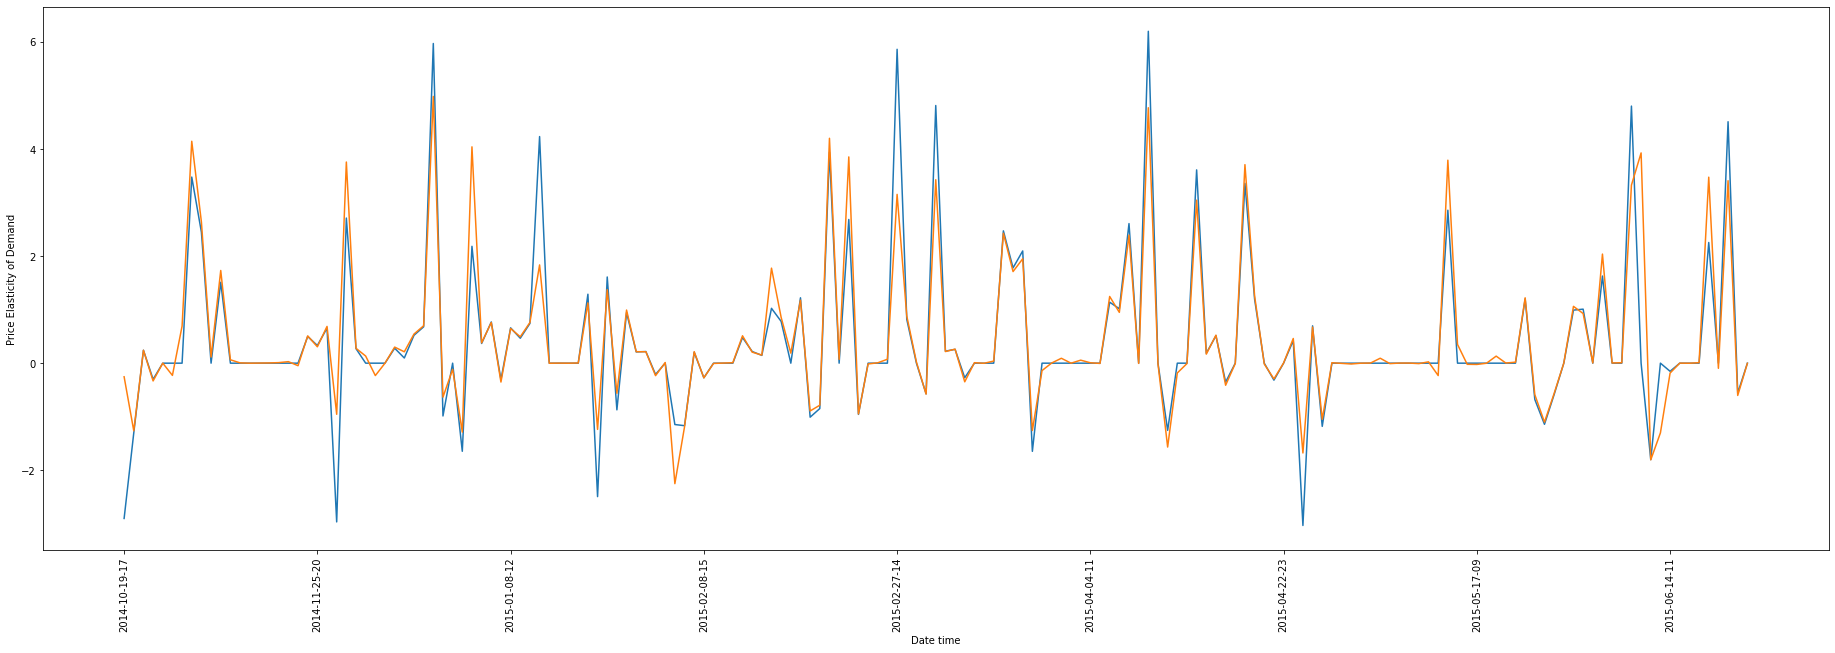

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [38]:
data = df
col_group = ['pickup_datetime', 'fare_amount', 'passenger_count','Label_Date']   # Group by columns
col_feature = ['fare_amount', 'passenger_count']   # Feature extraction columns
input_columns = ['sPED']
target_column = ['sPED']
n_window = 3
threshold = 0.05

cv_splits = 5
test_split = 0.1


data_output = pipeline(data, 
                       threshold, 
                       input_columns, 
                       target_column, 
                       col_group, 
                       col_feature, 
                       n_window, 
                       cv_splits, 
                       test_split,
                       group_by='hour')
data_output